In [1154]:
import pandas as pd
import math
from fancyimpute import KNN, MICE
import re
import numpy as np

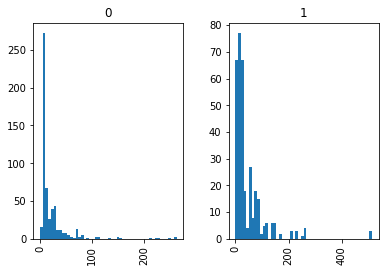

In [1155]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.Fare.hist(by=train['Survived'], bins=50)
# train.Fare[train['Survived'] == 1].hist(color='g', bins=10, sharex=False)

full = pd.concat([train.drop(columns='Survived'), test], axis=0)
# print(train.columns)
# print(test.columns)
# print(full.columns)
# print(len(train), len(test), len(full))

test_passenger_ids = test['PassengerId']

In [1156]:
print(full.isna().any())


PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked        True
dtype: bool


In [1157]:
full[full['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


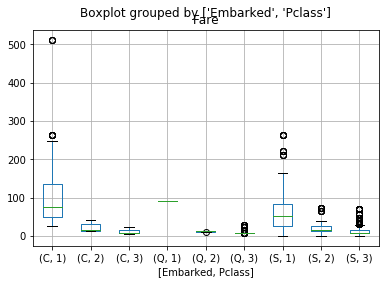

In [1158]:
full.boxplot(column=['Fare'], by=['Embarked','Pclass'])

In [1159]:
"""We can see that C1 corresponds most closely to Fare of $80
Thus we should replace the NaN value for Embarked column as 'C'"""

"We can see that C1 corresponds most closely to Fare of $80\nThus we should replace the NaN value for Embarked column as 'C'"

In [1160]:
full.Embarked.fillna('S', inplace=True)
full[full['PassengerId'].isin([62,830]) ]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


In [1161]:
full[full['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [1162]:
"""Dropping Ticket column as it doesn't seem to be useful"""
full.drop(columns=['Ticket'], inplace=True)

In [1163]:
#Add deck feature
full['Cabin'] = full['Cabin'].fillna(10)

#We will use the first letter of the cabin attribute as the deck name, and transform it to a number
def get_deck_numerical(deck):
    if deck == 10 or deck == '10':
        return deck
    
    return ord(deck[0].upper()) - ord('A') + 1 # take ascii value of cabin, subtract value of A and add 1 to 
                                               # adjust to start from 1

full['Deck'] = full['Cabin'].apply(get_deck_numerical)
print(full[['Deck', 'Cabin']])

#Drop cabin as it is not useful now
full.drop(columns=['Cabin'], inplace=True)

     Deck        Cabin
0      10           10
1       3          C85
2      10           10
3       3         C123
4      10           10
5      10           10
6       5          E46
7      10           10
8      10           10
9      10           10
10      7           G6
11      3         C103
12     10           10
13     10           10
14     10           10
15     10           10
16     10           10
17     10           10
18     10           10
19     10           10
20     10           10
21      4          D56
22     10           10
23      1           A6
24     10           10
25     10           10
26     10           10
27      3  C23 C25 C27
28     10           10
29     10           10
..    ...          ...
388    10           10
389    10           10
390     2          B24
391     4          D28
392    10           10
393    10           10
394    10           10
395     3          C31
396    10           10
397     2          B41
398    10           10
399    10  

In [1164]:
print(full.isna().any())

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Fare            True
Embarked       False
Deck           False
dtype: bool


In [1165]:
embarked_mapping = {}
for i in range(len(full.Embarked.unique())):
    embarked_mapping[full.Embarked.unique()[i]] = i+1

def get_embarked_numerical(embarked_value):
    return embarked_mapping[embarked_value]

full['Embarked'] = full['Embarked'].apply(get_embarked_numerical)


In [1166]:
# Add Title attribute
title_regexp = ' [A-Za-z]+\.'

def get_title(name):
    title_search = re.search(title_regexp, name)
    if title_search:
        return title_search.group(0).strip()
    return ""

full['Title'] = full['Name'].apply(get_title)
# print(full['Title'].groupby(full['Title']).groups.keys())
full['Title'] = full['Title'].replace('Mlle.', 'Miss.')
full['Title'] = full['Title'].replace('Ms.', 'Miss.')
full['Title'] = full['Title'].replace('Mme.', 'Mrs.')
# print(full['Title'].groupby(full['Title']).agg('count'))



title_mapping = {}
common_titles = ['Mr.', 'Miss.', 'Mrs.', 'Master.']

def get_title_numerical(title):
    if title in common_titles:
        return common_titles.index(title)+1
    return 5 # rare title

full['Title'] = full['Title'].apply(get_title_numerical)


In [1167]:
#Convert Sex to numerical
def get_sex_numerical(sex):
    return 1 if sex == 'male' else 2

full['Sex'] = full['Sex'].apply(get_sex_numerical)

In [1168]:
#Add family-size feature
full['familySize'] = full.apply(lambda row: row.SibSp + row.Parch+1, axis=1)


In [1169]:
#Add alone feature
full['isAlone'] = full.apply(lambda x: 1 if x.SibSp==0 and x.Parch==0 else 0, axis =1)

In [1170]:
x_full = full.drop(columns=['PassengerId',  'Name'])
x_full.columns = colnames


In [1171]:
colnames = x_full.columns
print(colnames)
print(x_full.isna().any())
x_full = pd.DataFrame(MICE().complete(x_full))

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck',
       'Title', 'familySize', 'isAlone'],
      dtype='object')
Pclass        False
Sex           False
Age            True
SibSp         False
Parch         False
Fare           True
Embarked      False
Deck          False
Title         False
familySize    False
isAlone       False
dtype: bool
[MICE] Completing matrix with shape (1309, 11)
[MICE] Starting imputation round 1/110, elapsed time 0.000
[MICE] Starting imputation round 2/110, elapsed time 0.002
[MICE] Starting imputation round 3/110, elapsed time 0.005
[MICE] Starting imputation round 4/110, elapsed time 0.006
[MICE] Starting imputation round 5/110, elapsed time 0.010
[MICE] Starting imputation round 6/110, elapsed time 0.012
[MICE] Starting imputation round 7/110, elapsed time 0.014
[MICE] Starting imputation round 8/110, elapsed time 0.015
[MICE] Starting imputation round 9/110, elapsed time 0.017
[MICE] Starting imputation round 10/110, elapsed 

In [1172]:
print(colnames)


Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck',
       'Title', 'familySize', 'isAlone'],
      dtype='object')


In [1173]:
x_full.columns = colnames


In [1174]:
#Bin fares
bins = [-1,10,50,100,200,400,1000000]
x_full['Fare'] = np.searchsorted(bins, x_full['Fare'].values)
x_full

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,familySize,isAlone
0,3.0,1.0,22.000000,1.0,0.0,1,1.0,10.0,1.0,2.0,0.0
1,1.0,2.0,38.000000,1.0,0.0,3,2.0,3.0,3.0,2.0,0.0
2,3.0,2.0,26.000000,0.0,0.0,1,1.0,10.0,2.0,1.0,1.0
3,1.0,2.0,35.000000,1.0,0.0,3,1.0,3.0,3.0,2.0,0.0
4,3.0,1.0,35.000000,0.0,0.0,1,1.0,10.0,1.0,1.0,1.0
5,3.0,1.0,28.495293,0.0,0.0,1,3.0,10.0,1.0,1.0,1.0
6,1.0,1.0,54.000000,0.0,0.0,3,1.0,5.0,1.0,1.0,1.0
7,3.0,1.0,2.000000,3.0,1.0,2,1.0,10.0,4.0,5.0,0.0
8,3.0,2.0,27.000000,0.0,2.0,2,1.0,10.0,3.0,3.0,0.0
9,2.0,2.0,14.000000,1.0,0.0,2,2.0,10.0,3.0,2.0,0.0


In [1175]:
#Bin ages
bins = [0,12,17,25,35,55,75,120]
x_full['Age'] = np.searchsorted(bins, x_full['Age'].values)

# print(x_full.isna().any())
x_full

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,familySize,isAlone
0,3.0,1.0,3,1.0,0.0,1,1.0,10.0,1.0,2.0,0.0
1,1.0,2.0,5,1.0,0.0,3,2.0,3.0,3.0,2.0,0.0
2,3.0,2.0,4,0.0,0.0,1,1.0,10.0,2.0,1.0,1.0
3,1.0,2.0,4,1.0,0.0,3,1.0,3.0,3.0,2.0,0.0
4,3.0,1.0,4,0.0,0.0,1,1.0,10.0,1.0,1.0,1.0
5,3.0,1.0,4,0.0,0.0,1,3.0,10.0,1.0,1.0,1.0
6,1.0,1.0,5,0.0,0.0,3,1.0,5.0,1.0,1.0,1.0
7,3.0,1.0,1,3.0,1.0,2,1.0,10.0,4.0,5.0,0.0
8,3.0,2.0,4,0.0,2.0,2,1.0,10.0,3.0,3.0,0.0
9,2.0,2.0,2,1.0,0.0,2,2.0,10.0,3.0,2.0,0.0


In [1209]:
X_train = x_full[:891]
X_test = x_full[891:]
print(len(X_train))
print(len(X_test))
X_train.columns

891
418


Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck',
       'Title', 'familySize', 'isAlone'],
      dtype='object')

In [1210]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss

classifiers = [
    KNeighborsClassifier(3),
    LinearSVC(),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    ExtraTreesClassifier()]

voting_classifier = VotingClassifier(estimators=[(str(i),classifiers[i]) for i in range(len(classifiers))] , voting='hard')

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)



In [1211]:
#Labels for the training and validation set
Y_train = train.Survived


In [1212]:
for train_index, val_index in sss.split(X_train, Y_train):
    x_tr, x_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = Y_train.iloc[train_index], Y_train.iloc[val_index]
    
    for clf in classifiers+[voting_classifier]:
        name = clf.__class__.__name__
        print(name)
        clf.fit(x_tr, y_tr)
        predictions = clf.predict(x_va)
        acc = accuracy_score(y_va, predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
            
            
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf]/10.0
    
print(acc_dict)

KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier
LinearSVC
SVC
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LogisticRegression
ExtraTreesClassifier
VotingClassifier
{'KNeighborsClassifier': 0.8889992617967654, 'LinearSVC': 0.9196720470218225, 'SVC': 0.9371471837320836, 'DecisionTreeClassifier': 0.8811622642643184, 'RandomForestClassifier': 0.9000913611705617, 'AdaBoostClassifier': 0.9253632384772337, 'GradientBoostingClassifier': 0.920304009701382, 'GaussianNB': 0.8866427040489139, 'LogisticRegression': 0.918629183709012, 'ExtraTreesClassifier': 0.8946586369639598, 'VotingClassifier': 0.9008888888888889}


/Users/goelakas/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [1207]:
#It seems that GradientBoostingClassifier performs the best
#We'll use that to do our predictions

final_predictions = []
for clf in classifiers:
    if clf.__class__.__name__ == 'SVC':
        final_predictions = clf.predict(X_test)

In [1208]:
final_predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [1197]:
result = pd.DataFrame()
result['PassengerId'] = test_passenger_ids
result['Survived'] = final_predictions

In [1198]:
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [1199]:
result.to_csv('result_8_binned_fare_and_used_SVC.csv', index=False)